Checking whether memory gets released properly

In [80]:
# instuctions for VLOG-enabled Tensorflow:
# https://github.com/openai/tf_dist/blob/master/grpc/parse_vlog_memory.py
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import re, os, sys
tf.__version__

'0.12.0-rc1'

# Common utils

In [90]:
# Setup utilities to parse __LOG_MEMORY__ statements in command-line
tensor_allocation_regex = re.compile(r"allocated_bytes: (?P<allocated_bytes>\d+).*.*allocation_id: (?P<allocation_id>\d+).*timestamp (?P<timestamp>\d+)")
tensor_output_regex = re.compile("""MemoryLogTensorOutput.* step_id: (?P<step_id>[-0123456789]+) kernel_name: \"(?P<kernel_name>[^"]+).*allocated_bytes: (?P<allocated_bytes>\d+).*allocation_id: (?P<allocation_id>\d+).*timestamp (?P<timestamp>\d+)""")   
tensor_deallocation_regex = re.compile(r"allocation_id: (?P<allocation_id>\d+).*timestamp (?P<timestamp>\d+)")

def _parse_logline(l):
    # There are 4 kinds of lines with __LOG_MEMORY__ tag
    # MemoryLogTensorDeallocation, MemoryLogTensorAllocation, MemoryLogStep,
    #
    # Example lines for debugging:
    # MemoryLogTensorDeallocation
    # 5143420588.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorDeallocation { allocation_id: 2 allocator_name: "cpu" } timestamp 5143420588459765

    # MemoryLogTensorAllocation
    # I 5143420588.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorAllocation { step_id: -6 kernel_name: "Unknown (from Proto)" tensor { dtype: DT_INT32 shape { dim { size: 3 } } allocation_description { requested_bytes: 12 allocated_bytes: 12 allocator_name: "cpu" allocation_id: 3 has_single_reference: true ptr: 29496256 } } } timestamp 5143420588526034

    # MemoryLogStep
    # I 5143420588.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogStep { step_id: 1 handle: "->Print:0//0/;0" } timestamp 5143420588718348

    # MemoryLogTensorOutput
    # I 5143420588.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorOutput { step_id: 1 kernel_name: "Const" tensor { dtype: DT_INT32 shape { dim { size: 3 } } allocation_description { requested_bytes: 12 allocated_bytes: 12 allocator_name: "cpu" allocation_id: 3 ptr: 29496256 } } } timestamp 5143420588932740
     
    # some weird initialization step 
    # if "step_id: -6" in l:
    #    return {}
    
    if 'MemoryLogTensorOutput' in l:
        m = tensor_output_regex.search(l)
        # assert m, l
        if not m:  # some Shape lines are missing bytes info, ie
            # I 5162643141.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorOutput { step_id: 5 kernel_name: "gradients/Shape" tensor { dtype: DT_INT32 shape { dim { } } } } timestamp 5162643141310124
            return {}
        d = {f: m.group(f) for f in ["timestamp", "allocation_id",
                                     "allocated_bytes", "kernel_name"]}
        d["timestamp"] = int(d["timestamp"])
        d["allocation_id"] = int(d["allocation_id"])
        d["allocated_bytes"] = int(d["allocated_bytes"])
    elif 'MemoryLogTensorAllocation' in l:
        m = tensor_allocation_regex.search(l)
        d = {f: int(m.group(f)) for f in ["timestamp", "allocation_id",
                                          "allocated_bytes"]}
        d["kernel_name"] = "<unknown>"
    elif 'MemoryLogTensorDeallocation' in l:
        m = tensor_deallocation_regex.search(l)
        assert m, l
        d = {f: int(m.group(f)) for f in ["timestamp", "allocation_id"]}
    else:
        d = {}
    return d

def memory_timeline(output):
    """Returns array of tuples representing memory actions
    (timestamp_nanoseconds, kernel_name, memory_bytes)
    memory is positive for allocations and negative for deallocations.
    timestamps are relative to the first memory allocation line found
    """
    
    parsed_lines = [_parse_logline(l) for l in output.split("\n")]
    parsed_lines = [l for l in parsed_lines if l] # remove Nones
    parsed_lines.sort(key=lambda l: l["timestamp"])
    first_timestamp = parsed_lines[0]["timestamp"]
    
    # Tensors that are output have two records (allocation and output)
    # since output comes after, overwrite allocation_map with output
    # info (it has kernel_name)
    allocation_map = {} # map of allocation_id->parsed_logline of allocation
    double_records = {} # map of ids which have both allocation and output
    for line in parsed_lines:
        if "kernel_name" in line:
            if line["allocation_id"] in allocation_map:
                double_records[line["allocation_id"]] = True
            line["allocation_id"]
            allocation_map[line["allocation_id"]] = line
            

    result = []
    for line in parsed_lines:
        if "kernel_name" in line:
            # ignore tensorallocation lines which will later have tensoroutput
            if (line["allocation_id"] in double_records and
                line["kernel_name"] == "<unknown>"):
                continue
            kernel_name = line["kernel_name"]
            allocated_bytes = line["allocated_bytes"]
        else: # deallocation
            allocation_line = allocation_map[line["allocation_id"]]
            kernel_name = allocation_line["kernel_name"]
            allocated_bytes = -allocation_line["allocated_bytes"]
        result.append((line["timestamp"]-first_timestamp, kernel_name,
                       allocated_bytes))
    return result


def print_memory_timeline(stderr):
    total_memory = 0
    for record in memory_timeline(stderr):
        timestamp, kernel_name, allocated_bytes = record
        if abs(allocated_bytes)<1000:
            continue  # ignore small allocations
        total_memory += allocated_bytes
        print("%9d %40s %11d %11d"%(timestamp, kernel_name, allocated_bytes, total_memory))

def plot_memory_timeline(stderr):
    total_memory = 0
    timestamps = []
    data = []
    for record in memory_timeline(stderr):
        timestamps.append(record[0]-1)
        data.append(total_memory)
        total_memory += record[-1]
        timestamps.append(record[0])
        data.append(total_memory)
    plt.plot(timestamps, data)
    
    
run_metadata = tf.RunMetadata()
def summarize(run_metadata=run_metadata):
    ss = tf.contrib.stat_summarizer.NewStatSummarizer(tf.get_default_graph().as_graph_def().SerializeToString())
    ss.ProcessStepStatsStr(run_metadata.step_stats.SerializeToString())
    print(ss.GetOutputString())
    
def create_session():
    config = tf.ConfigProto(graph_options=tf.GraphOptions(
        optimizer_options=tf.OptimizerOptions(
            opt_level=tf.OptimizerOptions.L0)))
    return tf.Session(config=config)

def printops(ops):
    print([op.name for op in ops])
    
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
def sessrun(*args, **kwargs):
    sess = create_session()
    sess.run(tf.global_variables_initializer())
    kwargs["run_metadata"] = run_metadata
    kwargs["options"] = run_options
    return sess.run(*args, **kwargs)

import tensorflow.contrib.graph_editor as ge
def run_after(a_tensor, b_tensor):
    """Force a to run after b"""
    ge.reroute.add_control_inputs(a_tensor.op, [b_tensor.op])
    

## Graph visualizer

In [335]:
# make things wide
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def=None, width=1200, height=800, max_const_size=32, ungroup_gradients=False):
    if not graph_def:
        graph_def = tf.get_default_graph().as_graph_def()
        
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    data = str(strip_def)
    if ungroup_gradients:
        data = data.replace('"gradients/', '"b_')
        #print(data)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(data), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:{}px;height:{}px;border:0" srcdoc="{}"></iframe>
    """.format(width, height, code.replace('"', '&quot;'))
    display(HTML(iframe))

## Redirector

In [74]:
import os
import sys

STDOUT = 1
STDERR = 2

# this hangs when pipe buffer is full

class FDRedirector(object):
    """ Class to redirect output (stdout or stderr) at the OS level using
        file descriptors.
    """ 

    def __init__(self, fd=STDOUT):
        """ fd is the file descriptor of the outpout you want to capture.
            It can be STDOUT or STERR.
        """
        self.fd = fd
        self.started = False
        self.piper = None
        self.pipew = None

    def start(self):
        """ Setup the redirection.
        """
        if not self.started:
            self.oldhandle = os.dup(self.fd)
            self.piper, self.pipew = os.pipe()
            os.dup2(self.pipew, self.fd)
            os.close(self.pipew)

            self.started = True

    def flush(self):
        """ Flush the captured output, similar to the flush method of any
        stream.
        """
        if self.fd == STDOUT:
            sys.stdout.flush()
        elif self.fd == STDERR:
            sys.stderr.flush()

    def stop(self):
        """ Unset the redirection and return the captured output. 
        """
        if self.started:
            self.flush()
            os.dup2(self.oldhandle, self.fd)
            os.close(self.oldhandle)
            f = os.fdopen(self.piper, 'r')
            output = f.read()
            f.close()

            self.started = False
            return output
        else:
            return ''

    def getvalue(self):
        """ Return the output captured since the last getvalue, or the
        start of the redirection.
        """
        output = self.stop()
        self.start()
        return output

redirect=FDRedirector(STDERR)
stderr = ""

from contextlib import contextmanager
@contextmanager
def grab_stderr():
    global stderr
    redirect.start();
    yield
    stderr = redirect.stop()
    
def open_tag(tag):
    sess.run(tf.Print(tf.constant(1), [tf.constant(1)], tag+"<BEGIN>"))
    
def close_tag(tag):
    sess.run(tf.Print(tf.constant(1), [tf.constant(1)], tag+"<END>"))
    
def grab_output(tag, filename="/tmp/jupyter.txt"):
    s = open(filename).read()
    opening_tag = tag+"<BEGIN>"
    ending_tag = tag+"<END>"
    starting_pos = s.rfind(opening_tag)
    ending_pos = s.rfind(ending_tag)
    return s[starting_pos:ending_pos]

## Threading redirector

In [1]:
import os
import sys
import time
import threading

STDOUT = 1
STDERR = 2

# this hangs when pipe buffer is full

class FDRedirector(object):
    """ Class to redirect output (stdout or stderr) at the OS level using
        file descriptors.
    """ 

    def __init__(self, fd=STDOUT):
        """ fd is the file descriptor of the outpout you want to capture.
            It can be STDOUT or STERR.
        """
        self.fd = fd
        self.started = False
        self.piper = None
        self.pipew = None
        self.output = ""
        self.should_stop = False

    def start(self):
        """ Setup the redirection.
        """
        if not self.started:
            self.oldhandle = os.dup(self.fd)
            self.piper, self.pipew = os.pipe()
            os.dup2(self.pipew, self.fd)
            os.close(self.pipew)

            self.started = True

    def flush(self):
        """ Flush the captured output, similar to the flush method of any
        stream.
        """
        if self.fd == STDOUT:
            sys.stdout.flush()
        elif self.fd == STDERR:
            sys.stderr.flush()

    def stop(self):
        """ Unset the redirection and return the captured output. 
        """
        if self.started:
            self.flush()
            os.dup2(self.oldhandle, self.fd)
            os.close(self.oldhandle)
            f = os.fdopen(self.piper, 'r')
            output = f.read()
            f.close()

            self.started = False
            return output
        else:
            return ''

    def getvalue(self):
        """ Return the output captured since the last getvalue, or the
        start of the redirection.
        """
        output = self.stop()
        self.start()
        return output
    
    def update_values(self):
        while not self.should_stop:
            time.sleep(0.01)
            self.output+=self.getvalue()
    
    def real_start(self):
        self.should_stop = False
        self.start()
        self.start_runner()
        
    def real_stop(self):
        self.should_stop = True
        time.sleep(10)
        if self.runner.is_alive():
            raise RuntimeError("Reading thread won't stop")
        self.output+=self.getvalue()
        
        return self.output
        
    def start_runner(self):
        self.runner = threading.Thread(target=self.update_values, args=())
        self.runner.start()

#redirect=FDRedirector(STDERR)

stderr = ""

from contextlib import contextmanager
@contextmanager
def grab_stderr():
    global stderr
    redirect = FDRedirector(STDERR)
    redirect.real_start()
    yield
    stderr = redirect.real_stop()

# Simple graph

In [75]:
tf.reset_default_graph()
a = tf.Variable(2., name="a")
b = tf.pow(a, 2, name="b")
c = tf.pow(b, 3, name="c")
sessrun(c)
summarize()

Total time (us): curr=1147 count=11 runs, avg 1.147 ms, 9 nodes defined 7 nodes observed
0.008 avg KB per run.

============ By run order (ms) =================
  [start]  [first]    [avg]	     [%] 	  [cdf%] 	      [Op]	[Name]
    0.000    0.042    0.042	  3.662%	  3.662%	          	_SOURCE
    0.071    0.157    0.157	 13.688%	 17.350%	     Const	b/y
    0.109    0.540    0.540	 47.079%	 64.429%	  Variable	a
    0.244    0.087    0.087	  7.585%	 72.014%	     Const	c/y
    0.667    0.055    0.055	  4.795%	 76.809%	  Identity	a/read
    0.735    0.104    0.104	  9.067%	 85.876%	       Pow	b
    0.853    0.162    0.162	 14.124%	100.000%	       Pow	c
1 runs, avg 1.147 ms, 9 nodes defined 7 nodes observed
0.008 avg KB per run.

============ Top by duration in ms =================
  [start]  [first]    [avg]	     [%] 	  [cdf%] 	      [Op]	[Name]
    0.109    0.540    0.540	 47.079%	 47.079%	  Variable	a
    0.853    0.162    0.162	 14.124%	 61.203%	       Pow	c
    0.071    0.157    0.157	 1

# Medium graph

In [17]:
n=1000*1000*25
tf.reset_default_graph()
a1 = tf.random_uniform(shape=(n,), name="a1")
a2 = tf.mul(a1, 2., name="a2")
a3 = tf.mul(a2, 2., name="a3")
a4 = tf.mul(a3, 2., name="a4")
c = tf.mul(a4, 3., name="cost")
b4 = tf.add(c, a4, name="b4")
b3 = tf.add(b4, a3, name="b3")
b2 = tf.add(b3, a2, name="b2")
b1 = tf.add(b2, a1, name="b1")

In [18]:
sess = create_session()


In [19]:
total_memory = 0
for record in memory_timeline(stderr):
    timestamp, kernel_name, allocated_bytes = record
    if abs(allocated_bytes)<1000:
        continue  # ignore small allocations
    total_memory += allocated_bytes
    print("%9d %20s %10d %10d"%(timestamp, kernel_name, allocated_bytes, total_memory))

 39752762     a1/RandomUniform  100000000  100000000
 51521085               a1/mul  100000000  200000000
 51624706     a1/RandomUniform -100000000  100000000
 62873624                   a1  100000000  200000000
 62971457               a1/mul -100000000  100000000
 71539763                   a2  100000000  200000000
 79764903                   a3  100000000  300000000
 86546363                   a4  100000000  400000000
 94408888                 cost  100000000  500000000
105218710                   b4  100000000  600000000
105289690                 cost -100000000  500000000
105641953                   a4 -100000000  400000000
117250163                   b3  100000000  500000000
117318474                   b4 -100000000  400000000
117684893                   a3 -100000000  300000000
131092040                   b2  100000000  400000000
131156038                   b3 -100000000  300000000
131741197                   a2 -100000000  200000000
142940432                   b1  100000000  300

## Memory plot

In [23]:
def plot_memory(stderr):
    total_memory = 0
    timestamps = []
    data = []
    for record in memory_timeline(stderr):
        timestamps.append(record[0]-1)
        data.append(total_memory)
        total_memory += record[-1]
        timestamps.append(record[0])
        data.append(total_memory)
    plt.plot(timestamps, data)

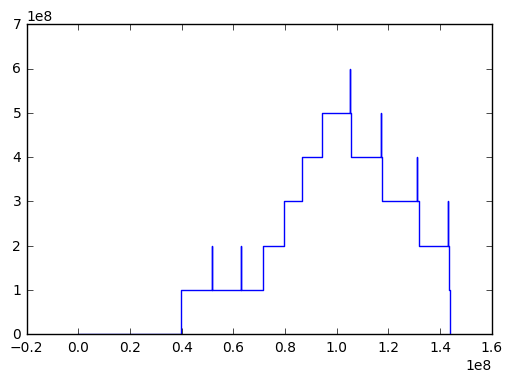

In [24]:
total_memory = 0
timestamps = []
data = []
for record in memory_timeline(stderr):
    timestamps.append(record[0]-1)
    data.append(total_memory)
    total_memory += record[-1]
    timestamps.append(record[0])
    data.append(total_memory)
plt.plot(timestamps, data)

# Rewrite the graph for efficiency manually

In [25]:
n=1000*1000*25
tf.reset_default_graph()
a1 = tf.random_uniform(shape=(n,), name="a1")
a2 = tf.mul(a1, 2., name="a2")
A2 = tf.mul(a1, 2., name="A2")
a3 = tf.mul(a2, 2., name="a3")
a4 = tf.mul(a3, 2., name="a4")
A4 = tf.mul(a4, 2., name="A4")
c =  tf.mul(a4, 3., name="cost")
b4 = tf.add(c, A4, name="b4")
b3 = tf.add(b4, a3, name="b3")
b2 = tf.add(b3, A2, name="b2")
b1 = tf.add(b2, a1, name="b1")

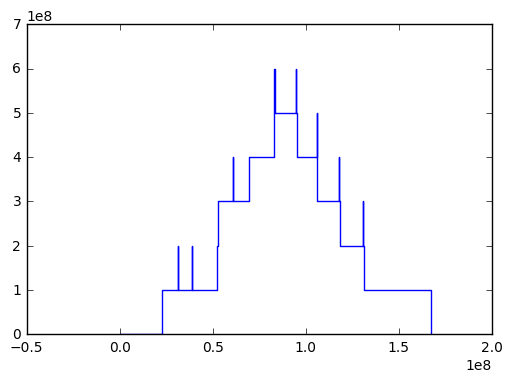

In [26]:
sess = create_session()
redirect.start();
sess.run(b1);
stderr = redirect.stop()
plot_memory(stderr)

In [27]:
total_memory = 0
for record in memory_timeline(stderr):
    timestamp, kernel_name, allocated_bytes = record
    if abs(allocated_bytes)<1000:
        continue  # ignore small allocations
    total_memory += allocated_bytes
    print("%9d %20s %10d %10d"%(timestamp, kernel_name, allocated_bytes, total_memory))

 22691426     a1/RandomUniform  100000000  100000000
 31121561               a1/mul  100000000  200000000
 31178772     a1/RandomUniform -100000000  100000000
 38841463                   a1  100000000  200000000
 38929271               a1/mul -100000000  100000000
 52169264                   A2  100000000  200000000
 52809745                   a2  100000000  300000000
 60650414                   a3  100000000  400000000
 60717234                   a2 -100000000  300000000
 69346731                   a4  100000000  400000000
 82773996                   A4  100000000  500000000
 83162878                 cost  100000000  600000000
 83204317                   a4 -100000000  500000000
 94739261                   b4  100000000  600000000
 94792320                 cost -100000000  500000000
 95130126                   A4 -100000000  400000000
105870922                   b3  100000000  500000000
105920962                   b4 -100000000  400000000
106262555                   a3 -100000000  300

In [28]:
run_after(A2, b3)
run_after(A4, c)

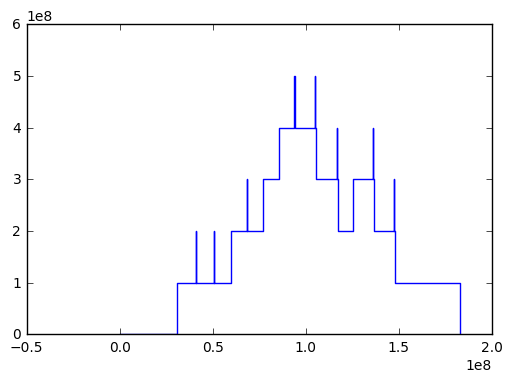

In [29]:
sess = create_session()
redirect.start();
sess.run(b1);
stderr = redirect.stop()
plot_memory(stderr)

In [30]:
total_memory = 0
for record in memory_timeline(stderr):
    timestamp, kernel_name, allocated_bytes = record
    if abs(allocated_bytes)<1000:
        continue  # ignore small allocations
    total_memory += allocated_bytes
    print("%9d %20s %10d %10d"%(timestamp, kernel_name, allocated_bytes, total_memory))

 30855829     a1/RandomUniform  100000000  100000000
 41000144               a1/mul  100000000  200000000
 41086614     a1/RandomUniform -100000000  100000000
 50624457                   a1  100000000  200000000
 50728597               a1/mul -100000000  100000000
 59861251                   a2  100000000  200000000
 68449844                   a3  100000000  300000000
 68543889                   a2 -100000000  200000000
 77135029                   a4  100000000  300000000
 85546359                 cost  100000000  400000000
 93934819                   A4  100000000  500000000
 94010573                   a4 -100000000  400000000
104751984                   b4  100000000  500000000
104821862                 cost -100000000  400000000
105425300                   A4 -100000000  300000000
116983044                   b3  100000000  400000000
117066767                   b4 -100000000  300000000
117460057                   a3 -100000000  200000000
125666337                   A2  100000000  300

# Plot gradients allocation

Instructions for updating:
Use `tf.global_variables_initializer` instead.


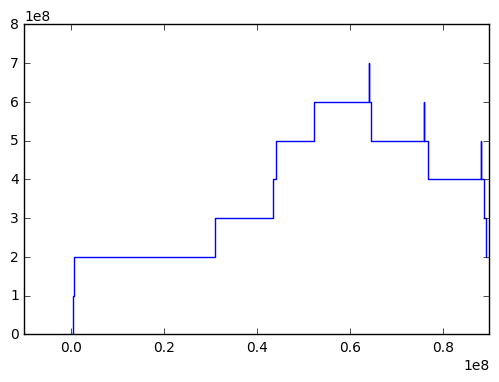

In [41]:
n=1000*1000*25
tf.reset_default_graph()
#a1 = tf.random_uniform(shape=(n,), name="a1")
a1 = tf.Variable(tf.random_uniform(shape=(n,)), name="a1")
a2 = tf.tanh(a1, name="a2")
a3 = tf.tanh(a2, name="a3")
a4 = tf.tanh(a3, name="a4")
cost = tf.reduce_sum(a4, name="cost")
grad = tf.gradients(cost, [a1])[0]

sess = create_session()
sess.run(tf.initialize_all_variables())
redirect.start();
sess.run(grad.op);
stderr = redirect.stop()
plot_memory(stderr)

#c =  tf.mul(a4, 3., name="cost")
#b4 = tf.add(c, A4, name="b4")
#b3 = tf.add(b4, a3, name="b3")
#b2 = tf.add(b3, A2, name="b2")
#b1 = tf.add(b2, a1, name="b1")

In [43]:
total_memory = 0
for record in memory_timeline(stderr):
    timestamp, kernel_name, allocated_bytes = record
    if abs(allocated_bytes)<1000:
        continue  # ignore small allocations
    total_memory += allocated_bytes
    print("%9d %30s %10d %10d"%(timestamp, kernel_name, allocated_bytes, total_memory))

   524107                             a1  100000000  100000000
   581954                        a1/read  100000000  200000000
 31013633                             a2  100000000  300000000
 43400896                             a3  100000000  400000000
 44004364       gradients/cost_grad/Tile  100000000  500000000
 52270796                             a4  100000000  600000000
 64082445     gradients/a4_grad/TanhGrad  100000000  700000000
 64163679                             a4 -100000000  600000000
 64523500       gradients/cost_grad/Tile -100000000  500000000
 75939734     gradients/a3_grad/TanhGrad  100000000  600000000
 76010501                             a3 -100000000  500000000
 76708326     gradients/a4_grad/TanhGrad -100000000  400000000
 88194983     gradients/a2_grad/TanhGrad  100000000  500000000
 88292636                             a2 -100000000  400000000
 88813138     gradients/a3_grad/TanhGrad -100000000  300000000
 89188661     gradients/a2_grad/TanhGrad -100000000  20

## Rewire the graph manually for better memory

In [181]:
n=1000*1000*25
tf.reset_default_graph()
#a1 = tf.random_uniform(shape=(n,), name="a1")
a0 = tf.Variable(tf.random_uniform(shape=(n,)), name="a0")
a1 = tf.identity(a0, name="a1")
a2 = tf.tanh(a1, name="a2")
a3 = tf.tanh(a2, name="a3")
a4 = tf.tanh(a3, name="a4")
cost = tf.reduce_sum(a4, name="cost")
grad = tf.gradients(cost, [a1])[0]

In [182]:
show_graph()

In [183]:
xs = [a0]
ys = [cost]
fwd_ops = ge.get_walks_intersection_ops(forward_seed_ops=[x.op for x in xs], backward_seed_ops=[y.op for y in ys])
copied_fwd_svg, info = ge.copy_with_input_replacements(ge.sgv(fwd_ops), {})
xs_copied = [info._transformed_ts[x] if isinstance(x, tf.Tensor) else info._transformed_ts[x._variable] for x in xs ]
ys_copied = [info._transformed_ts[y] for y in ys]

In [184]:
show_graph()

In [185]:
grads = tf.gradients(ys_copied, xs_copied)

In [186]:
show_graph()

In [187]:
ys_copied = [info._transformed_ts[y] for y in ys]
xs_copied = [info._transformed_ts[x] if isinstance(x,tf.Tensor) else info._transformed_ts[x._variable] for x in xs]

In [188]:
bwd_ops = ge.get_walks_intersection_ops(forward_seed_ops=[x.op for x in xs_copied],
                                            backward_seed_ops=grads)

In [189]:
printops(fwd_ops)

['a0', 'a0/read', 'a1', 'a2', 'a3', 'a4', 'cost']


In [190]:
printops(bwd_ops)

['a0_1', 'a0/read_1', 'a1_1', 'a2_1', 'gradients_1/a2_1_grad/TanhGrad', 'a3_1', 'a4_1', 'gradients_1/a3_1_grad/TanhGrad', 'gradients_1/a4_1_grad/TanhGrad']


In [191]:
# this takes ops and returns Tensors
remember = ge.filter_ts_from_regex(fwd_ops, 'a3')

In [192]:
printops(remember)

['a1:0', 'a3:0']


In [193]:
# this takes Tesnors
replaced_ts = [info._transformed_ts[t] for t in remember]

In [194]:
printops(replaced_ts)

['a1_1:0', 'a3_1:0']


In [206]:
printops(bwd_ops)

['a0_1', 'a0/read_1', 'a1_1', 'a2_1', 'gradients_1/a2_1_grad/TanhGrad', 'a3_1', 'a4_1', 'gradients_1/a3_1_grad/TanhGrad', 'gradients_1/a4_1_grad/TanhGrad']


In [195]:
ge.reroute_a2b_ts(remember, replaced_ts, can_modify=bwd_ops)

3

In [204]:
show_graph(width=2000, height=4000)

In [212]:
n=1000*1000*25
tf.reset_default_graph()
#a1 = tf.random_uniform(shape=(n,), name="a1")
a0 = tf.Variable(tf.random_uniform(shape=(n,)), name="a0")
a1 = tf.identity(a0, name="a1")
a2 = tf.tanh(a1, name="a2")
a3 = tf.tanh(a2, name="a3")
a4 = tf.tanh(a3, name="a4")
cost = tf.reduce_sum(a4, name="cost")
#grad = tf.gradients(cost, [a1])[0]
xs = [a0]
ys = [cost]
fwd_ops = ge.get_walks_intersection_ops(forward_seed_ops=[x.op for x in xs], backward_seed_ops=[y.op for y in ys])
copied_fwd_svg, info = ge.copy_with_input_replacements(ge.sgv(fwd_ops), {})
xs_copied = [info._transformed_ts[x] if isinstance(x, tf.Tensor) else info._transformed_ts[x._variable] for x in xs ]
ys_copied = [info._transformed_ts[y] for y in ys]


grads = tf.gradients(ys_copied, xs_copied)

bwd_ops = ge.get_walks_intersection_ops(forward_seed_ops=[x.op for x in xs_copied],
                                            backward_seed_ops=grads)


In [213]:
printops(bwd_ops)

['a0_1', 'a0/read_1', 'a1_1', 'a2_1', 'gradients/a2_1_grad/TanhGrad', 'a3_1', 'a4_1', 'gradients/a3_1_grad/TanhGrad', 'gradients/a4_1_grad/TanhGrad']


In [214]:
bwd_ops=[bwd_ops[i] for i in [4, 7, 8]]

In [215]:
printops(bwd_ops)

['gradients/a2_1_grad/TanhGrad', 'gradients/a3_1_grad/TanhGrad', 'gradients/a4_1_grad/TanhGrad']


In [216]:
remember = ge.filter_ts_from_regex(fwd_ops, 'a3')
replaced_ts = [info._transformed_ts[t] for t in remember]
show_graph()

In [217]:
ge.reroute_a2b_ts(remember, replaced_ts, can_modify=bwd_ops)
show_graph(width=2000)

In [ ]:
iterate over all remembered nodes, for each remembered node child, add dependency on previous remembered node child or cost

In [ ]:
for i in range(len(remember)):
    if i == 0:
        run_after(child(remember[i]), cost)
    else:
        run_after(child(remember[i]), child(remember[i-1]))

In [101]:
replaced_ts[]

[<tf.Tensor 'a1_1:0' shape=(25000000,) dtype=float32>,
 <tf.Tensor 'a3_1:0' shape=(25000000,) dtype=float32>]

Instructions for updating:
Use `tf.global_variables_initializer` instead.


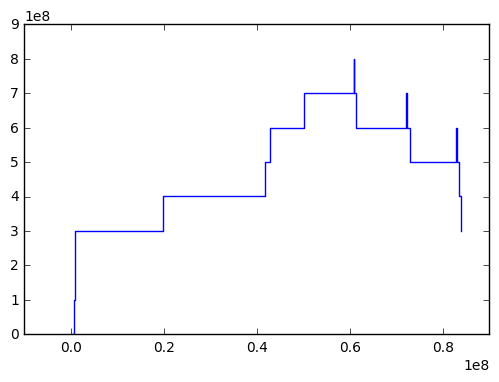

In [90]:
sess = create_session()
sess.run(tf.initialize_all_variables())
redirect.start();
sess.run(grad.op);
stderr = redirect.stop()
plot_memory(stderr)

In [91]:
replaced_ts[0]

<tf.Tensor 'a1_1:0' shape=(25000000,) dtype=float32>

In [93]:
run_after(replaced_ts[0], cost)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


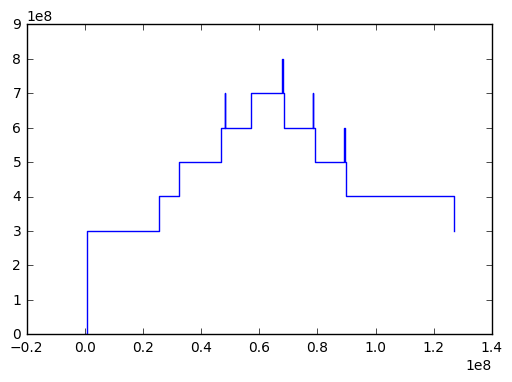

In [98]:
sess = create_session()
sess.run(tf.initialize_all_variables())
redirect.start();
sess.run(grads);
stderr = redirect.stop()
plot_memory(stderr)

In [99]:
print_memory_timeline(stderr)

   751373                             a0  100000000  100000000
   788769                        a0/read  100000000  200000000
   812320                             a1  100000000  300000000
 25505485                           a2_1  100000000  400000000
 32218122                             a2  100000000  500000000
 46739649   gradients_2/cost_1_grad/Tile  100000000  600000000
 48151215                             a3  100000000  700000000
 48197908                             a2 -100000000  600000000
 57227563                           a4_1  100000000  700000000
 67988836 gradients_2/a4_1_grad/TanhGrad  100000000  800000000
 68061666                           a4_1 -100000000  700000000
 68456245   gradients_2/cost_1_grad/Tile -100000000  600000000
 78576044 gradients_2/a3_1_grad/TanhGrad  100000000  700000000
 78628205                             a3 -100000000  600000000
 79095393 gradients_2/a4_1_grad/TanhGrad -100000000  500000000
 89322348 gradients_2/a2_1_grad/TanhGrad  100000000  60

## Simpler graph

In [422]:
n=1000*1000*25
tf.reset_default_graph()
a1 = tf.placeholder(tf.float32, name="a1", shape=(n,))
a2 = tf.tanh(a1, name="a2")
a3 = tf.tanh(a2, name="a3")
cost = tf.reduce_sum(a3, name="cost")
xs = [a1]
ys = [cost]
fwd_ops = ge.get_walks_intersection_ops(forward_seed_ops=[x.op for x in xs], backward_seed_ops=[y.op for y in ys])
grads = tf.gradients(ys, xs)
#copied_fwd_svg, info = ge.copy_with_input_replacements(ge.sgv(fwd_ops), {})
#xs_copied = [info._transformed_ts[x] if isinstance(x, tf.Tensor) else info._transformed_ts[x._variable] for x in xs ]
#ys_copied = [info._transformed_ts[y] for y in ys]
#grads = tf.gradients(ys_copied, xs_copied)
#bwd_ops = ge.get_walks_intersection_ops(forward_seed_ops=[x.op for x in xs_copied],
#                                            backward_seed_ops=grads)


In [423]:
printops(fwd_ops)

['a1', 'a2', 'a3', 'cost']


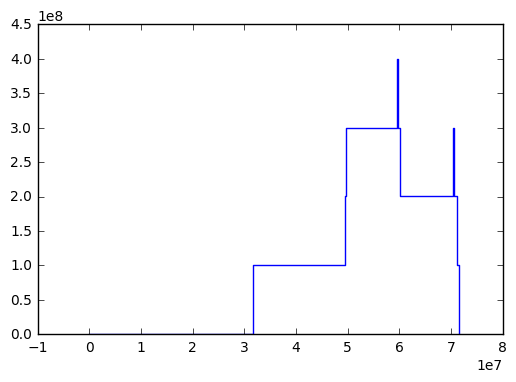

In [424]:
sess = create_session()
redirect.start();
sess.run(grads[0].op, feed_dict={a1:np.zeros((n,))})
stderr = redirect.stop()
plot_memory_timeline(stderr)

In [425]:
print_memory_timeline(stderr)

 31622726                                       a2   100000000   100000000
 49554548                                       a3   100000000   200000000
 49663968                 gradients/cost_grad/Tile   100000000   300000000
 59604658               gradients/a3_grad/TanhGrad   100000000   400000000
 59670548                                       a3  -100000000   300000000
 60210197                 gradients/cost_grad/Tile  -100000000   200000000
 70434778               gradients/a2_grad/TanhGrad   100000000   300000000
 70506752                                       a2  -100000000   200000000
 71158042               gradients/a3_grad/TanhGrad  -100000000   100000000
 71528833               gradients/a2_grad/TanhGrad  -100000000           0


In [309]:
show_graph(ungroup_gradients=True)

In [426]:
# save everything between a2 and cost
remember_ts = ge.filter_ts_from_regex(fwd_ops, "a1|a3")
printops(remember_ts)

['a1:0', 'a3:0']


In [427]:
intermediate_ops = ge.get_walks_intersection_ops(forward_seed_ops=[remember_ts[0].op], backward_seed_ops=[remember_ts[1].op])
intermediate_ops = intermediate_ops[1:-1]  # remove starting/endpoints
printops(intermediate_ops)

['a2']


In [428]:
copied_sgv, info = ge.copy_with_input_replacements(ge.sgv(intermediate_ops), {})

In [429]:
show_graph(ungroup_gradients=True)

In [430]:
bwd_ops = ge.filter_ops_from_regex(tf.get_default_graph(), "gradients/")

In [431]:
printops(bwd_ops)

['gradients/Shape', 'gradients/Const', 'gradients/Fill', 'gradients/cost_grad/Reshape/shape', 'gradients/cost_grad/Reshape', 'gradients/cost_grad/Tile/multiples', 'gradients/cost_grad/Tile', 'gradients/a3_grad/TanhGrad', 'gradients/a2_grad/TanhGrad']


In [432]:
printops(info._transformed_ops)

['a2']


In [433]:
intermediate_copied_ops = [info._transformed_ops[y] for y in intermediate_ops]

In [434]:
printops(intermediate_copied_ops)

['a2_1']


In [435]:
intermediate_copied_ts = [op.outputs[0] for op in intermediate_copied_ops]
intermediate_ts = [op.outputs[0] for op in intermediate_ops]

In [436]:
# b left dangling
ge.reroute_a2b_ts(intermediate_copied_ts, intermediate_ts, can_modify=bwd_ops)

1

In [410]:
show_graph()

In [447]:
def run_op_after(a_op, b_op):
    """Force a to run after b"""
    print("Adding %s to run after %s"%(a_op.name, b_op.name))
    ge.reroute.add_control_inputs(a_op, [b_op])

In [453]:
cost_grad = ge.filter_ops_from_regex(tf.get_default_graph(), "gradients/a3_grad/TanhGrad")

In [454]:
printops(cost_grad)

['gradients/a3_grad/TanhGrad']


In [449]:
printops(intermediate_copied_ops)

['a2_1']


In [455]:
# force copied intermediate ops to run after cost grad evaluation
for cost_op in cost_grad:
    for intermediate_op in intermediate_copied_ops:
        run_op_after(intermediate_op, cost_op)

Adding a2_1 to run after gradients/a3_grad/TanhGrad


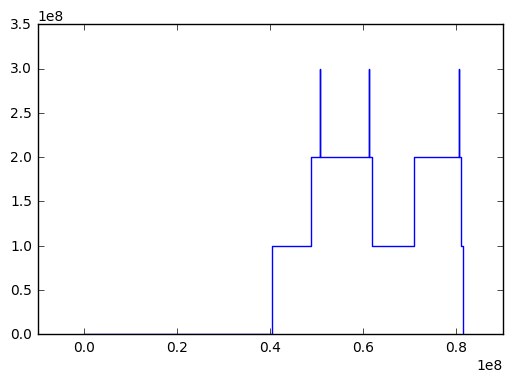

In [456]:
sess = create_session()
redirect.start();
sess.run(grads[0].op, feed_dict={a1:np.zeros((n,))})
stderr = redirect.stop()
plot_memory_timeline(stderr)

In [445]:
tf.get_default_graph().as_graph_def()

node {
  name: "a1"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: 25000000
        }
      }
    }
  }
}
node {
  name: "a2"
  op: "Tanh"
  input: "a1"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
}
node {
  name: "a3"
  op: "Tanh"
  input: "a2"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
}
node {
  name: "Const"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
          dim {
            size: 1
          }
        }
        int_val: 0
      }
    }
  }
}
node {
  name: "cost"
  op: "Sum"
  input: "a3"
  input: "Const"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "Tidx"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "keep_dims"
    value {

In [417]:
print_memory_timeline(stderr)

 41721136                                       a2   100000000   100000000
 51268960                 gradients/cost_grad/Tile   100000000   200000000
 51296229                                       a3   100000000   300000000
 51349327                                       a2  -100000000   200000000
 66828945                                       a4   100000000   300000000
 66903780                                       a3  -100000000   200000000
 66906681                                     a2_1   100000000   300000000
 83736359                                     a3_1   100000000   400000000
 83862398               gradients/a4_grad/TanhGrad   100000000   500000000
 83895032                                       a4  -100000000   400000000
 84307309                 gradients/cost_grad/Tile  -100000000   300000000
 96180502               gradients/a3_grad/TanhGrad   100000000   400000000
 96241543                                     a3_1  -100000000   300000000
 96835333               g

In [334]:
show_graph(ungroup_gradients=True)

node {
  name: "a1"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: 25000000
        }
      }
    }
  }
}
node {
  name: "a2"
  op: "Tanh"
  input: "a1"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
}
node {
  name: "a3"
  op: "Tanh"
  input: "a2"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
}
node {
  name: "Const"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
          dim {
            size: 1
          }
        }
        int_val: 0
      }
    }
  }
}
node {
  name: "cost"
  op: "Sum"
  input: "a3"
  input: "Const"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "Tidx"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "keep_dims"
    value {

# Allocation for snake graph

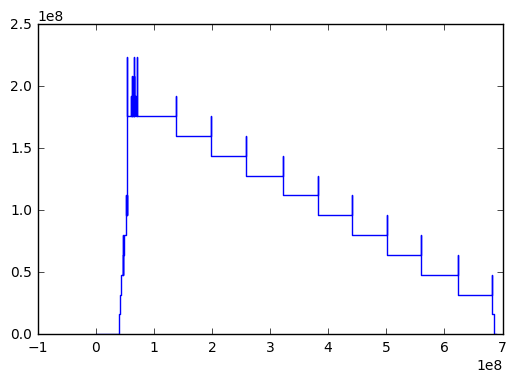

In [463]:
tf.reset_default_graph()

n=2000
a = tf.random_uniform(shape=(n,n))
for i in range(10):
    a = tf.matmul(a, tf.random_uniform(shape=(n,n)))

sess = tf.Session()
sess.run(a)
plot_memory_timeline()

In [388]:
tf.reset_default_graph()

n=2000
a = tf.random_uniform(shape=(n,n), name="matmul00")
for i in range(10):
    if i>1:
        with tf.control_dependencies([a]):
            leaf = tf.random_uniform(shape=(n,n), name="leaf"+str(i))
            a = tf.matmul(a, leaf, name="matmul"+str(i))

In [389]:
config = tf.ConfigProto(inter_op_parallelism_threads=10, intra_op_parallelism_threads=1, graph_options=tf.GraphOptions(optimizer_options=tf.OptimizerOptions(opt_level=tf.OptimizerOptions.L0)))
sess = tf.Session(config=config)

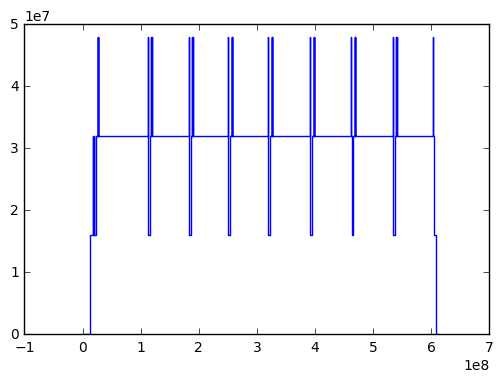

In [390]:
open_tag('mem')
sess.run(a)
close_tag('mem')
stderr=grab_output('mem')
plot_memory_timeline(stderr)

In [391]:
print_memory_timeline(stderr)

 13141568                   matmul00/RandomUniform    16000000    16000000
 17682354                             matmul00/mul    16000000    32000000
 17780584                   matmul00/RandomUniform   -16000000    16000000
 19024011                                 matmul00    16000000    32000000
 19064549                             matmul00/mul   -16000000    16000000
 23361344                      leaf2/RandomUniform    16000000    32000000
 25906411                                leaf2/mul    16000000    48000000
 26033818                      leaf2/RandomUniform   -16000000    32000000
 27073309                                    leaf2    16000000    48000000
 27140754                                leaf2/mul   -16000000    32000000
112769316                                  matmul2    16000000    48000000
112847291                                 matmul00   -16000000    32000000
112862438                                    leaf2   -16000000    16000000
115292228                

In [387]:
tf.get_default_graph().as_graph_def()

node {
  name: "matmul00/shape"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
          dim {
            size: 2
          }
        }
        tensor_content: "\320\007\000\000\320\007\000\000"
      }
    }
  }
}
node {
  name: "matmul00/min"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
        }
        float_val: 0.0
      }
    }
  }
}
node {
  name: "matmul00/max"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
        }
        float_val: 1.0
      }
    }
  }
}
node {
  name: "matmul00/RandomUniform"
  op: "RandomUniform"
  input: "matmul00/shape"
  attr {
    key: "T"
    va

In [32]:
for line in stderr.split('\n'):
    if 'LOG_MEMORY' in line:
        print(line.strip()[len('I 5353225381.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__'):])

 MemoryLogTensorAllocation { step_id: -6 kernel_name: "Unknown (from Proto)" tensor { dtype: DT_FLOAT shape { dim { size: 1111 } } allocation_description { requested_bytes: 4444 allocated_bytes: 4444 allocator_name: "cpu" allocation_id: 169 has_single_reference: true ptr: 61732032 } } } timestamp 5353673268863810
 MemoryLogTensorDeallocation { allocation_id: 169 allocator_name: "cpu" } timestamp 5353673268931599
 MemoryLogTensorAllocation { step_id: -6 kernel_name: "Unknown (from Proto)" tensor { dtype: DT_FLOAT shape { dim { size: 1111 } } allocation_description { requested_bytes: 4444 allocated_bytes: 4444 allocator_name: "cpu" allocation_id: 170 has_single_reference: true ptr: 61732032 } } } timestamp 5353673268982171
 MemoryLogTensorAllocation { step_id: -6 kernel_name: "Unknown (from Proto)" tensor { dtype: DT_FLOAT shape { dim { size: 1111 } } allocation_description { requested_bytes: 4444 allocated_bytes: 4444 allocator_name: "cpu" allocation_id: 171 has_single_reference: true p

In [239]:
tf.reset_default_graph()
sess = tf.Session()
a = tf.Variable([2, 2, 2])
b = tf.square(a)
c = tf.square(b)
sess.run(tf.initialize_all_variables())
sess.run(c)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


array([16, 16, 16], dtype=int32)

In [240]:
b0 = sess.run(b)

In [242]:
b0

array([4, 4, 4], dtype=int32)

In [243]:
b0[1] = 0

In [244]:
sess.run(c, feed_dict={b:b0})

array([16,  0, 16], dtype=int32)

# Memory allocation bug

In [457]:
tf.reset_default_graph()
a = tf.ones(())
a0 = a
for i in range(100):
    a = tf.tanh(a)
grad = tf.gradients(a, a0) 

In [460]:
len(tf.get_default_graph().as_graph_def().node)

204

In [ ]:
sess = create_session()
redirect.start();
sess.run(grads[0].op, feed_dict={a1:np.zeros((n,))})
stderr = redirect.stop()
plot_memory_timeline(stderr)